In [31]:
from abc import ABC, abstractmethod
from pandas import DataFrame, Series, read_csv
from numpy import std
import matplotlib.pyplot as plt

At first, I need utility class for column names

In [32]:
class ColumnNames:

    def __init__(self,
                 open_str: str = None,
                 high_str: str = None,
                 low_str: str = None,
                 close_str: str = None,
                 adj_close_str: str = None,
                 volume_str: str = None):
        self.open_str = open_str
        self.high_str = high_str
        self.low_str = low_str
        self.close_str = close_str
        self.adj_close_str = adj_close_str
        self.volume_str = volume_str


Then, class that represents any indicator. Any indicator can be calculable, so this is just an abstract class that allows lazy evaluation with caching both for indicator and strategy based on it.

In [33]:
class Calculable(ABC):

    BUY = 1
    HOLD = 0
    SELL = -1

    def __init__(self,
                 data: DataFrame,
                 mem: int = None,
                 column_names: ColumnNames = None):
        self._data = data
        self._mem = mem
        self._column_names = column_names
        self._result = None
        self._strategy = None

    @property
    def result(self) -> Series:
        if self._result is None:
            self._result = self.__calc__()
        return self._result

    @property
    def strategy(self) -> Series:
        if self._strategy is None:
            self._strategy = self.__strategy__()
        return self._strategy

    @abstractmethod
    def __calc__(self):
        pass

    @abstractmethod
    def __strategy__(self):
        pass


Now, we need classes, that represent:
1. SMA 
2. EMA
3. Stochastic %K
4. Stochastic %D, 
5. Larry Williams %R
6. Commodity Channel Index 
7. Relative Strength Index.

In [34]:
# SMA and EMA
class SMA(Calculable):

    def __calc__(self) -> Series:

        data = self._data[self._column_names.adj_close_str]
        data_size = len(data)

        dates = []
        values = []

        start = self._mem - 1
        for i in range(start, data_size):
            ma = sum(data[i - start: i + 1]) / self._mem
            dates.append(self._data.index.values[i])
            values.append(ma)
        df = Series(data=values, index=dates)
        df.index.name = "Date"
        return df

    def __strategy__(self):
        # No strat
        pass

class EMA(Calculable):

    def __calc__(self) -> Series:
        data = self._data[self._column_names.adj_close_str].values
        start = self._mem - 1
        data_size = len(data)
        dates = []
        values = []
        weight = 2 / (self._mem + 1)

        for i in range(start, data_size):
            prev = i - start - 1
            if prev < 0:
                ema = sum(data[i - start: i + 1]) / self._mem
            else:
                ema = weight * data[i] + (1 - weight) * values[prev]
            dates.append(self._data.index.values[i])
            values.append(ema)

        df = Series(data=values, index=dates)
        df.index.name = "Date"
        return df

    def __strategy__(self):
        # No strategy
        pass

In [35]:
# Stochastic %K and Stochastic %D
class STCK(Calculable):

    def __calc__(self) -> Series:

        low_data = self._data[self._column_names.low_str]
        high_data = self._data[self._column_names.high_str]
        close_data = self._data[self._column_names.close_str]

        dates = []
        values = []

        start = self._mem - 1
        for i in range(start, len(close_data)):
            min_price = min(low_data[i - start: i + 1])
            max_price = max(high_data[i - start: i + 1])
            stck = ((close_data[i] - min_price) / (max_price - min_price)) * 100

            dates.append(self._data.index.values[i])
            values.append(stck)

        df = Series(data=values, index=dates)
        df.index.name = "Date"
        return df

    def __strategy__(self) -> Series:
        dates = []
        strat = []

        for date in self.result.index:
            value = self.result.loc[date]

            pos = Calculable.HOLD
            if value < 20:
                pos = Calculable.BUY
            elif value > 80:
                pos = Calculable.SELL

            dates.append(date)
            strat.append(pos)

        df = Series(data=strat, index=dates)
        df.index.name = "Date"
        return df


class STCD(Calculable):

    def __calc__(self) -> Series:
        column_names = ColumnNames(adj_close_str="STCK")
        stcd = SMA(self._data, mem=self._mem, column_names=column_names).result
        return stcd

    def __strategy__(self):
        dates = []
        strat = []

        for date in self.result.index:
            value = self.result.loc[date]

            pos = Calculable.HOLD
            if value < 20:
                pos = Calculable.BUY
            elif value > 80:
                pos = Calculable.SELL

            dates.append(date)
            strat.append(pos)

        df = Series(data=strat, index=dates)
        df.index.name = "Date"
        return df


In [36]:
# Larry Williams %R
class LWR(Calculable):

    def __calc__(self) -> Series:

        low_data = self._data[self._column_names.low_str]
        high_data = self._data[self._column_names.high_str]
        close_data = self._data[self._column_names.close_str]

        dates = []
        values = []

        start = self._mem - 1
        for i in range(start, len(close_data)):
            min_price = min(low_data[i - start: i + 1])
            max_price = max(high_data[i - start: i + 1])
            lwr = (max_price - close_data[i]) / (max_price - min_price) * -100

            dates.append(self._data.index.values[i])
            values.append(lwr)

        df = Series(data=values, index=dates)
        df.index.name = "Date"
        return df

    def __strategy__(self) -> Series:
        dates = []
        strat = []

        for date in self.result.index:
            value = self.result.loc[date]

            pos = Calculable.HOLD
            if value < -80:
                pos = Calculable.BUY
            elif value > -20:
                pos = Calculable.SELL

            dates.append(date)
            strat.append(pos)

        df = Series(data=strat, index=dates)
        df.index.name = "Date"
        return df

In [37]:
# CCI and RSI

class CCI(Calculable):

    def __calc__(self) -> Series:
        high_data = self._data[self._column_names.high_str]
        low_data = self._data[self._column_names.low_str]
        close_data = self._data[self._column_names.close_str]

        data_size = len(close_data)

        Ms = [(high_data[i] + low_data[i] + close_data[i]) / 3 for i in range(data_size)]

        SMs = []

        start = self._mem - 1

        for i in range(start, data_size):
            sm = sum(Ms[i - start: i + 1]) / self._mem
            SMs.append(sm)

        Ds = []

        start = self._mem - 1
        for i in range(start, data_size):
            coefs = [abs(Ms[x] - SMs[i - start]) for x in range(i - start, i + 1)]
            d = sum(coefs) / self._mem
            Ds.append(d)

        dates = []
        values = []

        for i in range(start, data_size):
            coef = (Ms[i] - SMs[i - start]) / (0.015 * Ds[i - start])
            dates.append(self._data.index.values[i])
            values.append(coef)

        df = Series(data=values, index=dates)
        df.index.name = "Date"
        return df

    def __strategy__(self):
        dates = []
        strat = []

        for date in self.result.index:
            value = self.result.loc[date]

            pos = Calculable.HOLD
            if value < -100:
                pos = Calculable.BUY
            elif value > 100:
                pos = Calculable.SELL

            dates.append(date)
            strat.append(pos)

        df = Series(data=strat, index=dates)
        df.index.name = "Date"
        return df

class RSI(Calculable):

    def __calc__(self) -> Series:
        close_data = self._data[self._column_names.close_str]
        Us = []
        Ds = []
        for i in range(1, len(close_data)):
            cur = close_data[i]
            prev = close_data[i - 1]
            Us.append(cur - prev if cur > prev else 0)
            Ds.append(prev - cur if prev > cur else 0)
        u_ema = EMA(DataFrame({"U": Us}), self._mem, column_names=ColumnNames(adj_close_str="U")).result
        d_ema = EMA(DataFrame({"D": Ds}), self._mem, column_names=ColumnNames(adj_close_str="D")).result

        dates = []
        values = []

        start = self._mem + 1 - 1
        for i in range(start, len(close_data)):
            date = self._data.index.values[i]

            rs = u_ema.values[i-start] / d_ema.values[i-start]
            rsi = 100 - (100 / (1 + rs))

            dates.append(date)
            values.append(rsi)

        df = Series(data=values, index=dates)
        df.index.name = "Date"
        return df

    def __strategy__(self) -> Series:
        dates = []
        strat = []

        for date in self.result.index:
            value = self.result.loc[date]

            pos = Calculable.HOLD
            if value < 20:
                pos = Calculable.BUY
            elif value > 80:
                pos = Calculable.SELL

            dates.append(date)
            strat.append(pos)

        df = Series(data=strat, index=dates)
        df.index.name = "Date"
        return df


In [38]:
class Strategy:

    def __init__(self,
                 main_set: DataFrame,
                 column_names: ColumnNames,
                 starting_money: int,
                 order_size: int,
                 transaction_percent: float,
                 training_set_size: int = 80,
                 default_memories: int = 10,
                 risk_free_rate: float = 3.5):
        self.main_set = main_set
        self.column_names = column_names
        self.starting_money = starting_money
        self.order_size = order_size
        self.transaction_percent = transaction_percent
        self.training_set_size = training_set_size
        self.default_memories = default_memories
        self.risk_free_rate = risk_free_rate

    def run(self):

        set_size = len(self.main_set)
        training_proc_end = int(self.training_set_size * set_size / 100)
        testing_proc_start = training_proc_end
        training_set = self.main_set.iloc[:training_proc_end]
        testing_set = self.main_set.iloc[testing_proc_start:]
        

        # For testing purposes
        # sma = SMA(training_set, memory, column_names).result
        # ema = EMA(training_set, memory, column_names).result
        # mom = Momentum(training_set, memory, column_names).result

        stck = STCK(training_set, self.default_memories, self.column_names)
        stcd = STCD(stck.result.to_frame("STCK"), self.default_memories)
        lwr = LWR(training_set, self.default_memories, self.column_names)
        # ado = ADO(training_set, memory, column_names).result # Bad performance
        cci = CCI(training_set, self.default_memories, self.column_names)
        rsi = RSI(training_set, self.default_memories, self.column_names)
        # macd = MACD(training_set, memory, column_names).result # Bad performance

        prices = training_set[self.column_names.adj_close_str]
        inds = {stck: STCK, stcd: STCD, lwr: LWR, cci: CCI, rsi: RSI}

        best = 0
        best_ind = None

        print("Training")
        print("Indicator Result Sharpe")
        for indicator in inds.keys():
            changes = self.run_strat(prices, indicator)
            ind_name = indicator.__class__.__name__
            print("%s: %f, %f" %
                  (ind_name, sum(changes) + self.starting_money, self.sharpe(changes)))

            plt.title("%s strategy" % ind_name)
            plt.plot(indicator.strategy.values)
            plt.show()
            plt.title("%s changes" % ind_name)
            plt.plot(self.starting_money + changes.values)
            plt.show()
            result = sum(changes) + self.starting_money
            if result > best:
                best_ind = inds[indicator]
                best = result

        print("\n")

        print("Best: %s %f" % (best_ind.__name__, best))
        if best_ind == STCD:
            stck = STCK(testing_set, self.default_memories, self.column_names)
            test_result = STCD(stck.result.to_frame("STCK"), self.default_memories)
        else:
            test_result = best_ind(testing_set, self.default_memories, self.column_names)

        prices = testing_set[self.column_names.adj_close_str]
        changes = self.run_strat(prices, test_result)
        result = sum(changes) + self.starting_money

        print("\n")
        print("Testing result: %f" % result)
        print("Testing sharpe: %f" % self.sharpe(changes))
    def sharpe(self, changes):
        rets = (sum(changes) / len(changes) / self.starting_money) * 100 + 100
        return (rets - self.risk_free_rate) / std(changes) * 1000

    def run_strat(self, prices, indicator):
        money = self.starting_money
        changes = []
        transaction_costs = 0
        amounts = 0
        dates = []

        for idx in indicator.strategy.index:
            strat = indicator.strategy[idx]
            if strat != Calculable.HOLD:
                raw_money = self.order_size * prices[idx]
                if idx == indicator.strategy.index[-1]:
                    raw_money = amounts * prices[idx]
                    strat = Calculable.SELL
                transaction_cost = self.transaction_percent * raw_money / 100
                order_expense = raw_money * strat + transaction_cost
                if (strat == Calculable.BUY and money >= order_expense)\
                        or \
                        (strat == Calculable.SELL and amounts >= self.order_size):
                    transaction_costs += transaction_cost
                    amounts += strat * self.order_size
                    dates.append(idx)
                    changes.append(-order_expense)
                    money -= order_expense
        return Series(data=changes, index=dates)


Training
Indicator Result Sharpe
STCK: 135974.663527, 15.552352


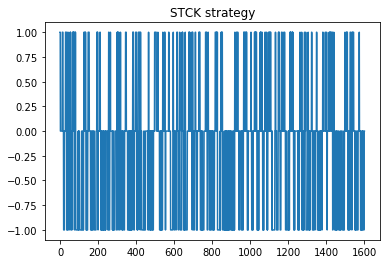

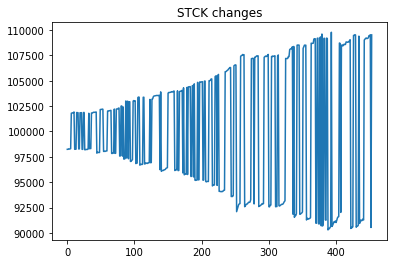

STCD: 117126.475008, 14.248669


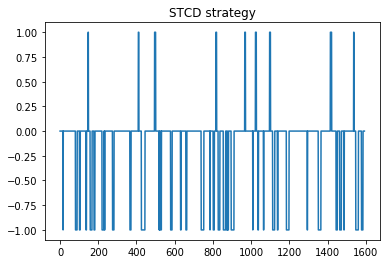

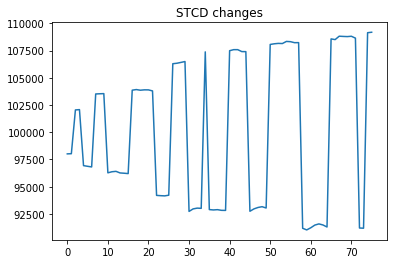

LWR: 135974.663527, 15.552352


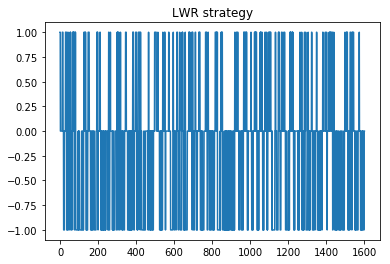

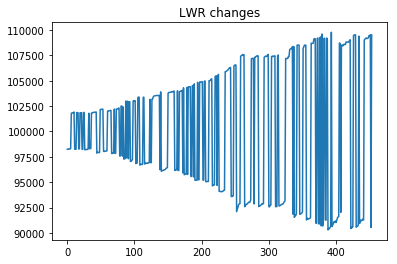

CCI: 141304.469423, 14.536561


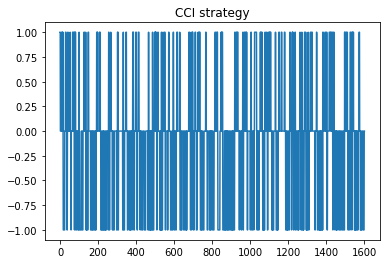

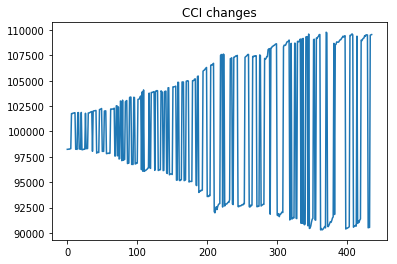

RSI: 112269.966469, 14.400739


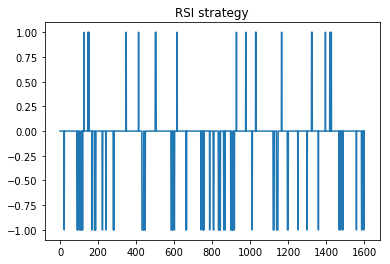

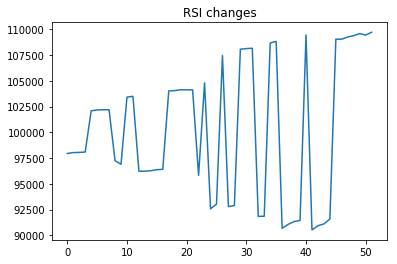



Best: CCI 141304.469423


Testing result: 113995.135027
Testing sharpe: 7.152317


In [39]:
main_set = read_csv("data/MA.csv", index_col=0)
column_names = ColumnNames(
    open_str="Open",
    close_str="Close",
    low_str="Low",
    high_str="High",
    adj_close_str="Adj Close",
    volume_str="Volume")
money = 100000
amount = 100
training_percent = 80 # In percents! 80%
memory = 10
transaction_cost_percent = 0.5 # In percents! It is actually 0.5%

strat = Strategy(main_set,
                 column_names,
                 money,
                 amount,
                 transaction_cost_percent,
                 training_percent,
                 memory)

strat.run()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-09-21,100.809998,101.309998,99.970001,101.260002,100.023888,3251900
2016-09-22,101.570000,102.230003,101.510002,102.120003,100.873383,3390600
2016-09-23,101.919998,102.099998,101.250000,101.660004,100.418999,2759400
2016-09-26,100.820000,101.830002,100.750000,101.160004,99.925117,3468900
2016-09-27,101.000000,101.650002,100.559998,101.449997,100.211555,3547700
